# Kinetic Monte Carlo

Certain processes are just too long to use MD simulations. Diffusion, nucleation of a new phase, structural transformations, etc. are on timescales that, if modeled with MD simulations, would use an impractical amount of computational resources.

What is a common characterisitic of these processes?

They transition between different configurations at a certain frequency. These frequencies determine the time evolution of the process as a whole.

Kinetic Monte Carlo (KMC) does not calculate these frequencies. Therefore, KMC does not give you a picture into the individual transitions between different states. Rather, KMC allows you to efficiently use these predetermined frequencies to evolve a system over time and calculate kinetic properties of the process.

### Diffusion

There are N possible positions for the vacancy.

If the vacancy is at position i, it can jump to M_i different neighboring positions.

Each jump occurs with frequencies v_ij, where j is a possible destination from i.

When a vacancy at i jumps to j, the vacancy can now jump to M_j different neighboring positions.

Each jump occurs with frequency v_jk, where k is a possible destination for j.

This process repeats.

Therefore, the overall diffusion process can be described by an N x N matrix of v_ij frequencies. Each element represents the frequency of the jump between ij 

Note: jump from i to j may be different from jump from j to i.

Note: if i -> j is not possible, V_ij = 0





The probability that i -> j, p_ij = v_ij / sum of frequencies for every possible jump from i.

The probability for these jumps is called a transition probability.

Frequencies for these jumps are called rate constants.

As mentioned before, the frequencies (rate constants) cannot be calculated using KMC. They *can* be calculated from transition state theory.

Note: This means for CCTM model, you will need to obtain the rate constants for each possible jump. Either use available values or learn how to use transition state theory.

### Assumptions

When defining a jump frequency, it is assumed that when i -> j, the vacancy doesn't retain information about how it arrived at i. This means that p_ij is independent of all previous jumps that occured before the vacancy arrived at i. This makes KMC a Markov process.

## Procedure

Start with a vacancy at a position marked i then randomly select one jump at position j from all possible jumps. 

Generate a random number, Z from 0-1. 

If p_ij $\ge$ Z, then accept this jump and move the vacancy to j.

If p_ij $\le$ Z, then do not accept the jump then start over by randomly selecting a possible jump.

This process results in the vacancy traveling throughout the lattice. Since a jump is more likely to be accepted if it has a larger rate constant, the vacancy will traverse a path that is or close to the most likely path.

To get the time a vacancy stays at position i, t_i, sum up the rate constants for all possible jumps from i to get v_tot. t_i = 1 / v_tot.
- check Notes

If you do this for every vacancy position, you have the time a vacancy spends in every positions. Therefore, for K steps of KMC, the process took the sum of the times at each vacancy position that was observed during the run.
- Therefore, for small Ks, since not every vacancy position will be observed, the overall time wont be representative of real life diffusion. Do we need sufficient steps of KMC to sample every vacancy position?


### Transition (Reaction) Rate Theory

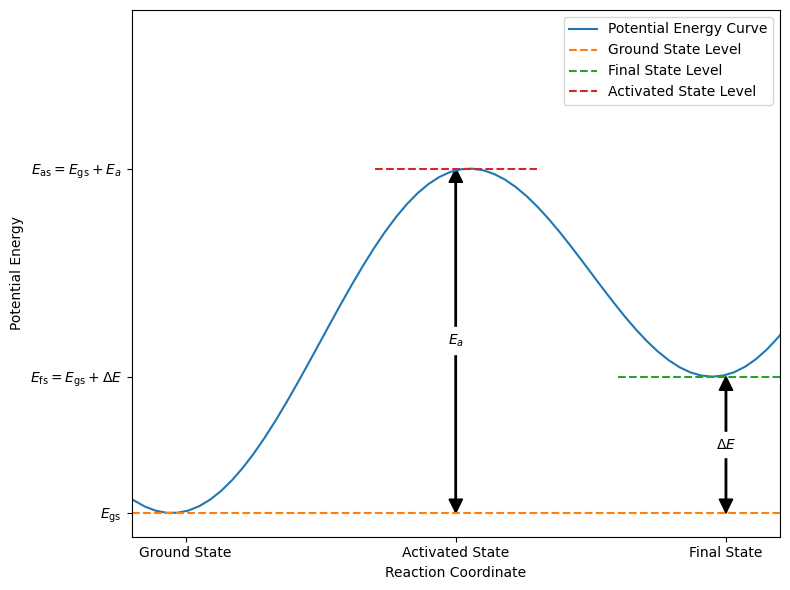

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def add_double_arrow(x, y_min, y_max, arrow_length_offset=0, head_width=0.0125, head_length=0.05, color='black'):
    """
    Add a double-sided arrow to a plot.

    Parameters:
        x (float): The x-coordinate of the arrow base.
        y_min (float): The starting y-coordinate (bottom) of the arrow.
        y_max (float): The ending y-coordinate (top) of the arrow.
        arrow_length_offset (float): Adjustment to the arrow length (positive to make shorter).
        head_width (float): Width of the arrowhead.
        head_length (float): Length of the arrowhead.
        color (str): Color of the arrows.
    """
    arrow_length = y_max - y_min - arrow_length_offset
    
    # Downward arrow
    plt.arrow(x, y_min, 0, arrow_length, head_width=head_width, head_length=head_length, fc=color, ec=color)
    
    # Upward arrow
    plt.arrow(x, y_min + arrow_length, 0, -arrow_length + arrow_length_offset, head_width=head_width, head_length=head_length, fc=color, ec=color)

# Generate data for the potential energy curve
x = np.linspace(0, 1, 100)
y = -np.sin(2 * np.pi * x) ** 2 + x

# Define key points for the ground, activated, and final states
x_gs, x_as, x_fs = 0.25, 0.5, 0.75
y_gs = np.min(y)
y_as = np.max(y[y.shape[0] // 4:3 * y.shape[0] // 4])
y_fs = np.min(y[y.shape[0] // 2:])

# Plot the potential energy curve
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Potential Energy Curve')
plt.xlabel('Reaction Coordinate')
plt.ylabel('Potential Energy')
plt.xlim(0.2, 0.8)
plt.xticks([x_gs, x_as, x_fs], ['Ground State', 'Activated State', 'Final State'])
plt.yticks([y_gs, y_as, y_fs], ['$E_\\text{gs}$', '$E_\\text{as} = E_\\text{gs} + E_a$', '$E_\\text{fs} = E_\\text{gs} + \\Delta E$'])

# Add dashed lines for energy levels
plt.axhline(y=y_gs, color='C1', linestyle='--', label='Ground State Level')
plt.axhline(y=y_fs, xmin=0.75, xmax=1, color='C2', linestyle='--', label='Final State Level')
plt.axhline(y=y_as, xmin=0.375, xmax=0.625, color='C3', linestyle='--', label='Activated State Level')

# Add double-sided arrows for activation energy and reaction energy
add_double_arrow(x=0.5, y_min=y_gs, y_max=y_as, arrow_length_offset=0.05)
add_double_arrow(x=0.75, y_min=y_gs, y_max=y_fs, arrow_length_offset=0.05)

# Add text annotations for energy levels
plt.text(0.5, (y_gs + y_as) / 2, '$E_a$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))
plt.text(0.75, (y_gs + y_fs) / 2, '$\\Delta E$', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='white'))

plt.legend()
plt.tight_layout()
plt.show()

Given we know the reaction path and Ea, such as this figure, what is the frequency of the transition between ground state and final state.

This is how we can use transition state theory to calculate the frequencies for each given vacancy jump.

[First description of transition state theory (reaction rate theory)](https://wash-primo.hosted.exlibrisgroup.com/permalink/f/1kqpcd6/WUSTL_SIERRA21314618)

### Basic Assumptions of Transition State Theory

1. Stable initial and sinal states
    - Initial and final configurations are stable and occur through a specific pathway
    - This pathway represents a path on the potential energy surface
2. Energy barrier and activate state
    - There is an energy barrier between the intial and final states. The most favorable path from the initial state to the final state is the path with the lowest energy barrier. The point at the peak of the activated state is called the transition state
    - This configuration is transient and cannot be isolated
3. Quasi-Equilibrium of the activated states
    - The system reaches a quasi-equilibrium where the initial state is in thermodynamic equilibrium with the transition state (this allows for the use of thermo equations).
    - The transition state vibrates in all directions perpendicular to the reaction coordinate but moves translationally along the reaction path. The initial and final state can vibrate in all directions
    - Assumptions may not hold if quantum tunneling or non-equilibrium dynamics play a significant role

### Main Results of Transition State Theory

The reaction rate (frequency) is given by

v = v_o * exp(-Ea/k_bT)

v: reaction rate or frequency of succesful transitions \
v_o: attempt frequency, represents the frequency of attemps to overcome the energy barrer \
Ea: activation energy \
k_B : boltzmann constant \
T: temperature

reaction rate is much smaller than attempt frequency

Tip: ***To test whether a process follows transition state theory, plot the ln(v) vs 1/T. If the process follows TST, the plot will be a straight line.***

This means we need to know the activation energy for every possible jump to get the frequency at every jump


## Application of the KMC to Oxygen Vacancy Diffusion in CeO2

Consider a cubic lattice w/ vacancies that can move to neighboring sites in 3D. Define the lattice as a 3D array where each site is either an oxygen atom or a vacancy. The vacancy will move w/ specific frequencies. The process of diffusion wil be simulated using KMC.

In [2]:
# Define cubic lattice parameters
lattice_size = 10
num_steps = 10000
temperature = 1000  # kelvin
activation_energy = 1   # eV
attempt_freq = 1e13 # Hz
boltz = 8.617333262e-5  # eV/k

Now we compute the rate constant (frequency of jump), assuming that the rate constant for each possible jump is the same

Assume the vacancy can move to six neighboring sites (two axial, four equitorial)

In [3]:
rate_constant = attempt_freq * np.exp(-activation_energy/(boltz * temperature))
print(f"rate_constant: {rate_constant:.2} Hz")

rate_constant: 9.1e+07 Hz


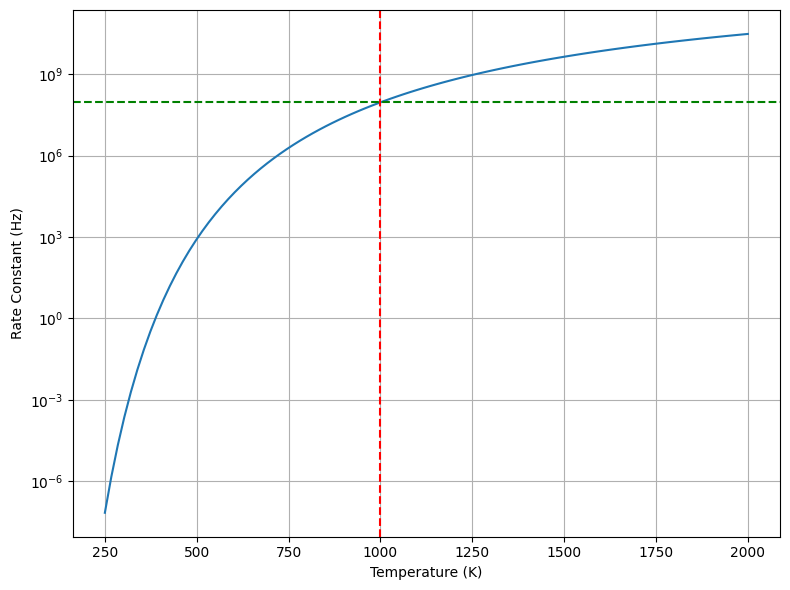

In [4]:
lst_t = np.linspace(250, 2000, 100)
lst_rate = attempt_freq * np.exp(-activation_energy/ (boltz * lst_t))


plt.figure(figsize=(8, 6))
plt.plot(lst_t, lst_rate)
plt.axvline(x=temperature, color='red', linestyle='--')
plt.axhline(y=rate_constant, color='green', linestyle='--')
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant (Hz)')
plt.tight_layout()
plt.grid(True)
plt.show()

Now initialize the lattice w/ a vacancy at the center and simulate the diffusion using KMC.

In [5]:
#Initialize lattice w a single vacancy

lattice = np.zeros((lattice_size, lattice_size, lattice_size), dtype=int)
vacancy_position = [(lattice_size // 2)] * 3
lattice[tuple(vacancy_position)] = 1

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for i in range(lattice_size):
    for j in range(lattice_size):
        for k in range(lattice_size):
            if lattice[i,j,k] == 1:
                ax.scatter(i, j, k, color='red', s=100, edgecolors='black', alpha=1)
            else:
                ax.scatter(i,j,k, color='blue',s=50, alpha=0.3)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel("z")
ax.set_title("initial configuration")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Now define the offsets for a cubic lattice to determine the neighboring sites for the vacancies

In [ ]:
neighbor = [
    (-1,0,0),(1,0,0),
    (0,-1,0),(0,1,0),
    (0,0,-1),(0,0,1)
]

[(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]


Now plot the neighbors by pointing an arrow to them from the vacancy position

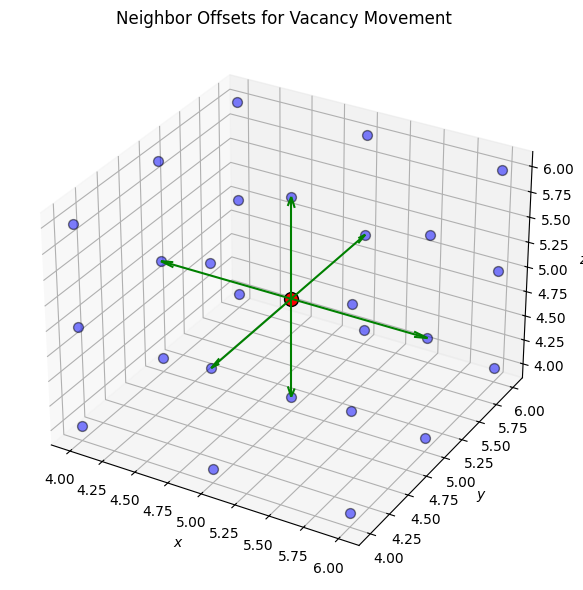

In [53]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection="3d")

# Plot only a subset of the lattice sites
for i in range(lattice_size // 2 - 1, lattice_size // 2 + 2):
    for j in range(lattice_size // 2 - 1, lattice_size // 2 + 2):
        for k in range(lattice_size // 2 - 1, lattice_size // 2 + 2):
            if (i,j,k) == tuple(vacancy_position):
                ax.scatter(i, j, k, color='red', s=100, edgecolors='black')
            else:
                ax.scatter(i, j, k, color='blue', s=50, edgecolors='black', alpha=0.5)

# Plot the neighbor offsets as arrows
for offset in neighbor:
    ax.quiver(vacancy_position[0],vacancy_position[1],vacancy_position[2], offset[0], offset[1], offset[2], color='green', arrow_length_ratio=0.1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Neighbor Offsets for Vacancy Movement')
plt.tight_layout()
plt.show()


Now keep track of the vacancy position and time during KMC. Randomly select a neighbor to move the vacancy to.

In [55]:
# Keep track of vacancy position and time

vacancy_positions = [tuple(vacancy_position)]
time = 0
time_steps = [time]

In [57]:
# Run the KMC

np.random.seed(42)

for step in range(num_steps):
    while True:
        possible_moves = []
        for offset in neighbor:
            neigh = [
                (vacancy_position[i] + offset[i]) % lattice_size
                for i in range(3)
            ]
            possible_moves.append(neigh)
        probability = [rate_constant for _ in possible_moves]
        probability /= np.sum(probability)

        chosen_move_idx = np.random.choice(len(possible_moves))
        new_position = possible_moves[chosen_move_idx]

        xi = np.random.random()

        if xi < probability[chosen_move_idx]:
            break
    lattice[tuple(vacancy_position)] = 0
    lattice[tuple(new_position)] = 1
    vacancy_position = new_position
    vacancy_positions.append(tuple(vacancy_position))

    total_rate = np.sum([rate_constant for _ in possible_moves])
    time += -np.log(np.random.random()) / total_rate
    time_steps.append(time)

In [58]:
# Convert the vacancy positions to a list of ASE atoms for visualization
from ase import Atoms
from ase.visualize import view

list_atoms = []
for position in vacancy_positions:
    # Create a list of chemical symbols for the lattice sites
    chemical_symbols = []
    for i in range(lattice_size):
        for j in range(lattice_size):
            for k in range(lattice_size):
                if (i, j, k) == position:
                    chemical_symbols.append('F')  # Vacancy
                else:
                    chemical_symbols.append('O')  # Oxygen atom

    # Create an ASE Atoms object for the lattice configuration
    atoms = Atoms(chemical_symbols, positions=[(i, j, k) for i in range(lattice_size) for j in range(lattice_size) for k in range(lattice_size)], pbc=True, cell=[lattice_size, lattice_size, lattice_size])
    list_atoms.append(atoms)

# Write the lattice configurations to a trajectory file for visualization
from ase.io import write
write('vacancy_diffusion.extxyz', list_atoms)

## Notes

- Study transition state theory

- Study Markov processes

- Understand what makes KMC different than regular (MC)

- What do we need?
    - list of rate constants for every possible jump

To get the time a vacancy stays at position i, t_i, sum up the rate constants for all possible jumps from i to get v_tot. t_i = 1 / v_tot.
- dont understand how this makes sense
- shouldnt it just be equal to 1 / v_max?
- Assume I can throw a dart in all four cardinal directions.
- Assume I can throw a dart to the North at 70/s
- Assume I can throw a dart to the South, East and West at 10/s.
- If I add these frequencies (100/s) and do 1s / 100, i get t = .01 s. These would mean I am throwing a dart once every .01 s. This means, overall, I am somehow getting rid of a dart faster then the fastest individual frequency (1s / 70 -> t = 0.014s). ***if a transition to one position occurs faster than the others, then the fastest time a jump could occur is 1 / v_max. However, this equation is saying that a jump can occur at faster than 1 / v_max.***

- consequence
    - assume you have two sites i and k
    - assume site i can jump to every position within the lattice with some given frequency, but it can jump to site j at a much higher frequency than other sites.
    - assume site k can only jump to site L, so the frequency associated with every other jump is 0. 
    - assume k -> L frequency is much lower than i -> j.
    - although k -> L has a much lower rate constant, it will occur 100% of the time, while i -> j competes with i -> M_i. So even though i -> j is a much quicker process it will occur with less probability than k -> L.
        - this is some kind of trapping event

how do we deal with traps?